## Inicjalizacja środowiska programistycznego

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
# sys.path.append("/content/drive/MyDrive/Colab Notebooks/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Rowery Kraków

**Zagadnienie:** przewidzieć liczbę rowerzystów na wybranej ulicy Krakowa na podstawie zliczeń z `window_size-1` poprzednich dni.

**Proszę:**

* pobrać dane używając komórki poniżej
* naprawić ewentualne błędy
* wypisać na ekran podsumowanie danych

In [2]:
import pandas as pd

file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWNYLoE3k3JegSt47hV66v5j7_Vh8jIdLRUhcMLrIAW4VcIZK-3W9rGoDSfnToUnCIb9DPngGAlgL6/pub?gid=0&single=true&output=csv'
df = pd.read_csv(file_url)

df = pd.read_csv(file_url, sep=",",parse_dates=[0])
#df = df.rename(columns={' ' : "Date"})
#df = df.fillna(0)
df.index = df['Date']
df.drop(columns=['Date'], inplace=True)
print(df.describe())

pass

       Armii Krajowej  Bora-Komorowskiego      Bulwary  Grzegórzecka  \
count     1638.000000         2523.000000  3118.000000   1638.000000   
mean       719.076923          743.670630  1557.954779   1547.595849   
std        532.154281          528.985847  1289.777766    788.181716   
min          0.000000           16.000000     0.000000     49.000000   
25%        245.000000          287.000000   445.000000    880.250000   
50%        589.500000          611.000000  1176.500000   1429.000000   
75%       1160.750000         1137.500000  2551.500000   2136.000000   
max       2207.000000         2335.000000  7075.000000   3543.000000   

       Kamieńskiego  Klimeckiego    Kopernika    Kotlarska     Mogilska  \
count   1636.000000  2524.000000  2522.000000  3118.000000  3118.000000   
mean     796.133863  1105.555468  1748.505155  1631.787364  2060.731879   
std      560.875987   768.261524  1069.393826  1138.473452  1364.129134   
min        7.000000    18.000000     0.000000     0

**Proszę:**

* zidentyfikowac dwie ulice o największym średnim natężeniu ruchu
* zachować nazwy tych ulic w zmiennych `train_street` i `val_street`

In [3]:
print(df.columns[:-5])
print(df.mean(numeric_only=True).sort_values(ascending=False).head(5))
train_street = "Mogilska"
val_street = "Kotlarska"


Index(['Armii Krajowej', 'Bora-Komorowskiego', 'Bulwary', 'Dworzec Główny',
       'Grzegórzecka', 'Kamieńskiego', 'Klimeckiego', 'Kopernika', 'Kotlarska',
       'Mogilska', 'Monte Cassino', 'Niepołomska', 'Nowohucka', 'Smoleńsk',
       'Tyniecka', 'Wadowicka', 'Wielicka'],
      dtype='object')
Mogilska        2060.731879
Kopernika       1748.505155
Kotlarska       1631.787364
Bulwary         1557.954779
Grzegórzecka    1547.595849
dtype: float64


**Proszę:**

* dla obu ulic, na oddzielnych panelach, narysować zliczenia rowerzystów w funkcji daty

**Uwaga:**
* daty znajdują się teraz w indeksie:
```Python
df.index
```

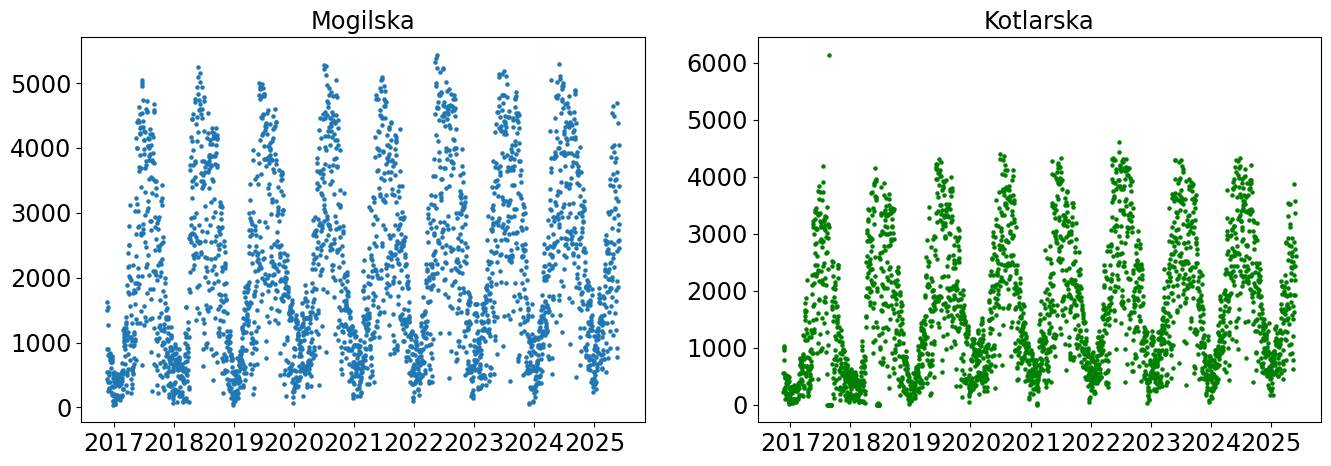

In [4]:

fig, axes = plt.subplots(1, 2, figsize=(16,5))
axes[0].scatter(df.index, df[train_street],s=5,label=train_street)
axes[0].set_title(train_street)
axes[1].scatter(df.index, df[val_street],s=5,c='green',label=val_street)
axes[1].set_title(val_street)
pass


**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, window_size, scale)` która przyjmuje obiekt `pandas.DataFrame` i zwraca obiekt `tf.Data.Dataset`.
Funkcja wykonuje następujące przekształcenia:

* dzieli dane na ciągi zliczeń z `window_size` dni
* normalizuje zliczenia o czynnik `1/scale`
* dzieli wiersze na `etykiety`: zliczenia z ostatniego dnia i `cechy`: zliczenia z wcześniejszych `window_size-1` dni
* dzieli zbiór na paczki o rozmiarze `16` i zachowuje go w pamięci podręcznej

**Wskazówki:**
* macierz danych z kolumny zbioru pandas można wyłuskać jako `df[...].values` lub podać po prostu `df[...]`
* macierze importujemy do `tf.data.Dataset` używając metody `from_tensor_slices(...)`

In [5]:
print(df[[train_street]].values)
print([train_street])

[[ 907]
 [ 438]
 [ 549]
 ...
 [3411]
 [2580]
 [2830]]
['Mogilska']


In [6]:
import datetime
def makeDataset(df, sequenceColumns, window_size, scale, batchSize=16):
    slidingWindowWidth = functools.partial(tf_text.sliding_window, width=window_size, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWidth((df[sequenceColumns].values)/scale))
    dataset = dataset.map(lambda x: tf.reshape(x, (window_size,len(sequenceColumns)))).map(lambda y: (y[:-1,:],y[-1,:])).batch(batchSize).cache()
    return dataset

x = makeDataset(df, [train_street], window_size=5, scale=1000, batchSize=1)
#print(x)
for item in x.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0])

Features: [0.907 0.438 0.549 1.501] Labels: [1.626]
Features: [0.438 0.549 1.501 1.626] Labels: [1.555]
Features: [0.549 1.501 1.626 1.555] Labels: [1.27]
Features: [1.501 1.626 1.555 1.27 ] Labels: [0.906]


**Proszę:**

* sprawdzić czy podział danych jest poprawny, tzn. czy widać że zliczenia w kolejnych przykładach pochodzą z kolejnych dni


In [ ]:
x = makeDataset(df, [train_street], window_size=5, scale=1000, batchSize=1)
y = makeDataset(df, [train_street], window_size=6, scale=1000, batchSize=1)

for item in x.take(1):
    print(colored("Label with window size 5:","blue"), item[1].numpy()[0])

for item in y.take(1):
    print(colored("Last of the sequence with window size 6:","blue"), item[0].numpy()[0,-1:,0], end=" ")

pass

Label with window size 5: [1.626]
Last of the sequence with window size 6: [1.626] 

Korzystając z funkcji `makeDataset(...)` proszę:

* utworzyć zbiory `train_dataset` i `val_dataset` ze zliczeniami z odpowiednich ulic.
* zbiór treningowy prosze ograniczyć do okresu `2017 - 2020`, a walidacyjny do okresu `2023 - 2024`
* szerokość okna ustawić na `32` dni
* skalę ustawić na `10_000`
* wypisać na ekran pierwsze 4 przykłady ze zbioru treningowego

**Wskazówka:**
* ograniczenie zakresu dat można uzyskać wybierając odpowiedni zakres wierszy w obiekcie `pandas.DataFrame` podawanym jako argument funkcji:
```Python
minTrainDate = datetime.date(2017, 1, 1)
maxTrainDate = datetime.date(2020, 12, 31)
df[minTrainDate:maxTrainDate]
```

In [7]:
window_size = 32
scale = 10_000

minTrainDate = datetime.date(2017, 1, 1)
maxTrainDate = datetime.date(2020, 12, 31)
minValDate = datetime.date(2022, 1, 1)
maxValDate = datetime.date(2024, 12, 31)
train_dataset = makeDataset(df[minTrainDate:maxTrainDate],[train_street],window_size=window_size,scale=scale, batchSize=16)
val_dataset = makeDataset(df[minValDate:maxValDate],[val_street],window_size=window_size,scale=scale, batchSize=16)
for item in train_dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0]*scale, end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]*scale)


Features: [172. 495. 414. 411. 369.  60.  55.  86. 326. 387. 366. 394. 479. 191.
 125. 514. 519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173.
 125. 331. 373.] Labels: [395.]
Features: [519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173. 125. 331.
 373. 395. 353. 374. 156. 112. 423. 406. 406. 383. 405. 169. 157. 368.
 449. 526. 569.] Labels: [411.]
Features: [ 353.  374.  156.  112.  423.  406.  406.  383.  405.  169.  157.  368.
  449.  526.  569.  411.  175.  189.  692.  449.  571.  512.  547.  278.
  290. 1199. 1224.  947. 1083. 1129. 1013.] Labels: [1046.]
Features: [ 175.  189.  692.  449.  571.  512.  547.  278.  290. 1199. 1224.  947.
 1083. 1129. 1013. 1046.  786. 1160. 1139.  897.  961.  668.  346. 1056.
 1324. 1220. 1293. 1390.  233.  548. 1112.] Labels: [1883.]


**Proszę:**

* zbudować model z warstwami LSTM:
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca tylko ostatni element sekwencji
    * warstwa gęsta, `1` neuron
* wypisać na ekran podsumowanie modelu    

In [8]:
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid',
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1))
], name ="Traffic_prediction")

model.summary()

pass

Model: "Traffic_prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

**Proszę:**

* przeprowadzić trening modelu przez `150` epok/ Trening powinien zawierać standardowe elementy:
    * harmonogram zmiany współczynnika uczenia
    * wywołanie wczesnego zatrzymania
    * rysowane historii funkcji straty
* kod trenowania zawrzeć w funkcji `trainModel(model, train_dataset, val_dataset)`


In [9]:
%%time

def trainModel(model, train_dataset, val_dataset):
    initial_learning_rate = 1E-3
    nStepsPerEpoch = train_dataset.cardinality().numpy()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                   decay_steps=nStepsPerEpoch*100,
                   decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse', metrics=[])

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=5,
                                                       patience=5, verbose=1)
    callbacks = [early_stop_callback]
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=150, callbacks=callbacks)
    return model


model = trainModel(model, train_dataset, val_dataset)

Epoch 1/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.1332 - val_loss: 0.0137
Epoch 2/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0206 - val_loss: 0.0133
Epoch 3/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0200 - val_loss: 0.0129
Epoch 4/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0194 - val_loss: 0.0125
Epoch 5/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0187 - val_loss: 0.0116
Epoch 6/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0170 - val_loss: 0.0088
Epoch 7/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0129 - val_loss: 0.0069
Epoch 8/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0110 - val_loss: 0.0067
Epoch 9/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0105 - val_loss: 0.0065
Epoch 10/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 11/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 12/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step

NameError: name 'history' is not defined

**Proszę:**

Dokończyć funkcję  `plotPrediction(...)`, która wykonuje rysunki kontrolne dla podanych ulic.
Dla każdej ulicy są rysowane:


* liczby zliczeń rzeczywista i prognozowaną dla okresu `2024.07.01 - 2024.07.31`
* iloraz `rzeczywista/prognozowana` dla okresu `2022 - 2024`
* histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`
* histogram`(rzeczywista-prognozowana)/rzeczywista` dla modelu prognozowania naiwnego: `jutro będzie tak jak dziś`
* histogramy są rysowane na jednym panelu


**Wskazówki:**
* zakresy dat można na wykresie można kontrolować w następujący sposób:
```Python
axes[index,0].set_xlim([datetime.date(2024, 7, 1), datetime.date(2024, 7, 31)])
axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
```
* do uzyskania modelu naiwnego można użyć funkcji `np.roll()`


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


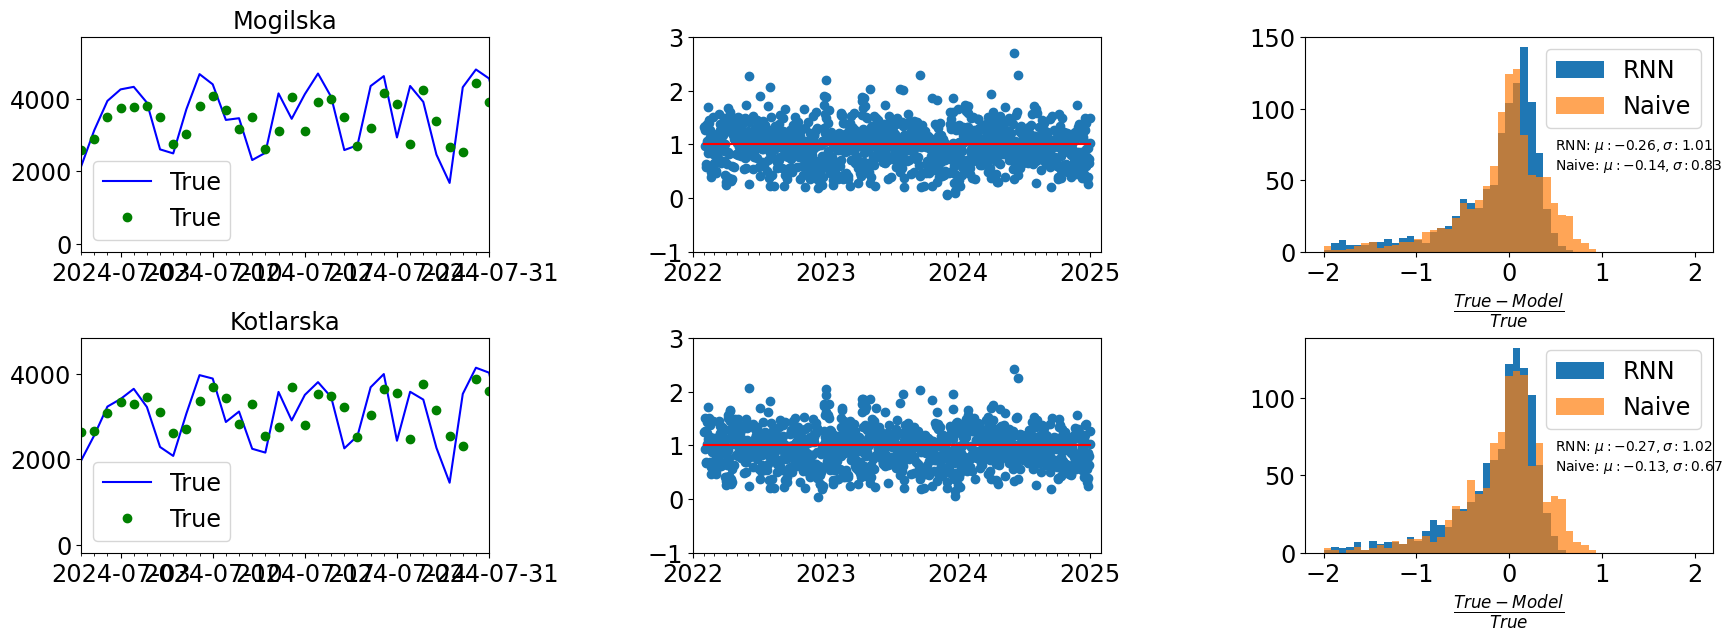

In [10]:
def plotPrediction(model, df, makeDataset, streets, window_size, scale):

    fig, axes = plt.subplots(2,3, figsize=(17,6))
    import matplotlib.dates as mdates

    for index,street in enumerate(streets[:2]):
        df_tmp = df[minValDate:maxValDate]
        dataset = makeDataset(df=df_tmp, sequenceColumns=[street],
                              window_size=window_size,
                              scale=scale)
        date = df_tmp.index[window_size-1:]
        y = df_tmp[street][window_size-1:].values
#...rozwiązanie...
        y_pred = model.predict(dataset)[:,0]*scale
        y_pred_naive = np.roll(y,1)
        axes[index,0].plot(date,y,'b',label="True")
        axes[index,0].plot(date,y_pred,'go',label="True")
        axes[index,0].set_xlim([datetime.date(2024, 6, 30), datetime.date(2024, 7, 31)])
        axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
        axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
        axes[index,0].set_title(street)
        axes[index,0].legend()

        axes[index,1].plot(date,y/y_pred,'o',label="True")
        axes[index,1].plot([date.min(),date.max()],[1,1],'r')
        axes[index,1].set_xlim([datetime.date(2022, 1, 1), datetime.date(2025, 1, 31)])
        axes[index,1].xaxis.set_major_locator(mdates.YearLocator())
        axes[index,1].xaxis.set_minor_locator(mdates.MonthLocator())
        axes[index,1].set_ylim([-1,3])

        ##
        counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")
        pull = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.5*counts.max(), r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        pull = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.4*counts.max(), r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        axes[index,2].legend()
        ##
        opadyColumn = "suma opadu dzień  [mm]"
        if opadyColumn in df.columns:
            ax2 = axes[index,0].twinx()
            ax2.plot(date, df_tmp[opadyColumn][window_size-1:], 'r');
            ax2.tick_params(axis='y', labelcolor="r")
            ax2.yaxis.label.set_color('red')
            ax2.set_ylabel("Day rain fall\n [arb. units]")
    ##
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.5, hspace=0.4)

##...rozwiązanie...

plotPrediction(model, df, makeDataset, [train_street, val_street], window_size, scale)

Zobaczmy czy dodanie danych o pogodzie poprawi wydajność modelu. Jako substytutu prognozy pogody użyjemy aktualnych danych pogodowych z dnia na który jest wykonywane przewidywanie ruchu rowerzystów.

Źródłem danych meteorologicznych jest Instytut Meteorologii i Gospodarki Wodnej – Państwowy Instytut Badawczy.
Dane o warunkach pogodowych pobierzemy z portalu [IMGW](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/).
Skorzystamy ze stacji Kraków-Balice.

In [11]:
import subprocess

# dowlnoad data
for year in range(2016, 2025):
    url = f"https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/{year}/{year}_566_s.zip"
    subprocess.run(["wget", url, "-P", "../data/Pogoda/"])

# unzip data
subprocess.run(["unzip","../data/Pogoda/*_566_s.zip", "-d","../data/Pogoda/"])

#remove zip archives
#file list expansion from * dos not work with subprocess
!rm -f ../data/Pogoda/*zip*

Dane załadujemy do obiektu Pandas dataframe.

**Proszę:**

Dokończyć funkcję `makeDataFrame(filePath)`, która wczytuje dane z pliku csv i tworzy obiekt `pandas.DataFrame`.
Funkcja wykonuje następujące operacje:

* wczytuje jedynie kolumny `2-22`
* używa kolumn `2-4` do utworzenia daty
* używa kodowania `Latin-1`
* usuwa kolumny zawierające `NaN`
* ustawia nazwy kolumn

In [72]:
import pandas as pd

def makeDataFrame(filePath):
    columns = ["Data","zachmurzenie",
               "prędkość wiatru [m/s]", "temperatura [°C]",
               "ciśnienie pary wodnej [hPa]", "wilgotność względna [%]",
                "ciśnienie na poziomie stacji [hPa]", "ciśnienie na poziomie morza [hPa]",
                "suma opadu dzień  [mm]","suma opadu noc   [mm]"]
    #BEING_SOLUTION
    # df = pd.read_csv(filePath, usecols=range(2, 23), encoding='Latin-1')
    cols =[]
    for i in range(2,22):
        cols.append(int(i))
    df = pd.read_csv(filePath, header = None, usecols=cols, sep =",", encoding='Latin-1', parse_dates = [[2,3,4]]).dropna(axis = 1)
    # df['Data'] = pd.to_datetime(df[[df.columns[0], df.columns[1], df.columns[2]]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
    # df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    # # Assign column names based on the remaining columns
    # new_column_names = ["year", "month", "day"] + columns[:len(df.columns) - 3]
    # df.columns = new_column_names
    df.columns = columns
    #END_SOLUTION
    return df

files = glob.glob("../data/Pogoda/s_d_t*.csv")
df_pogoda = pd.concat([makeDataFrame(file) for file in files])
df_pogoda.describe()

<ipython-input-72-3160888673>:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filePath, header = None, usecols=cols, sep =",", encoding='Latin-1', parse_dates = [[2,3,4]]).dropna(axis = 1)
<ipython-input-72-3160888673>:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filePath, header = None, usecols=cols, sep =",", encoding='Latin-1', parse_dates = [[2,3,4]]).dropna(axis = 1)
<ipython-input-72-3160888673>:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filePath, header = None, usecols=cols, sep =",", encoding='Latin-1', parse_dates = [[2,3,4]]).dropna(axis = 1)
<ipython-input-72-3

,Data,prędkość wiatru [m/s],temperatura [°C],ciśnienie pary wodnej [hPa],wilgotność względna [%],ciśnienie na poziomie stacji [hPa],ciśnienie na poziomie morza [hPa],suma opadu dzień [mm],suma opadu noc [mm]
count,3104,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000
mean,2020-03-31 12:00:00.000000256,3.130831,9.795941,10.013756,77.481443,987.839691,1017.100258,0.964530,0.901965
min,2016-01-01 00:00:00,0.100000,-19.400000,1.100000,35.100000,960.400000,989.600000,0.000000,0.000000
25%,2018-02-14 18:00:00,2.000000,3.400000,6.200000,69.250000,983.100000,1011.900000,0.000000,0.000000
50%,2020-03-31 12:00:00,2.900000,9.700000,9.000000,78.800000,988.200000,1017.100000,0.000000,0.000000
75%,2022-05-16 06:00:00,3.900000,16.800000,13.400000,87.100000,992.800000,1022.300000,0.300000,0.300000
max,2024-06-30 00:00:00,12.100000,27.300000,23.600000,100.000000,1014.200000,1045.200000,59.100000,26.800000
std,NaN,1.586419,8.133597,4.668930,12.083677,7.909359,8.282100,3.212421,2.726454


In [29]:
list(range(2,22))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Połączymy obiekty dataframe z danymi o zliczeniach i pogodzie. Dla obu zbiorów ustawiamy datę jako indeks - dzięki temu zapewnimy synchronizację wierszy między oboma zbiorami.

In [73]:
# set date as a index
df_pogoda.index = df_pogoda["Data"]

# drop index columns from weather df to avoid duplication
df_pogoda.drop(columns=["Data"], inplace=True)

# merge two dataframes. Only common dates are kept
df_merged = df.join(df_pogoda, how="inner")
df_merged.describe()

,Armii Krajowej,Bora-Komorowskiego,Bulwary,Grzegórzecka,Kamieńskiego,Klimeckiego,Kopernika,Kotlarska,Mogilska,Monte Cassino,...,Temperatura minimalna przy gruncie [°C],Suma dobowa opadów [mm],prędkość wiatru [m/s],temperatura [°C],ciśnienie pary wodnej [hPa],wilgotność względna [%],ciśnienie na poziomie stacji [hPa],ciśnienie na poziomie morza [hPa],suma opadu dzień [mm],suma opadu noc [mm]
count,1302.000000,2187.000000,2782.000000,1302.000000,1300.000000,2188.000000,2186.000000,2782.000000,2782.000000,2420.000000,...,2782.000000,2750.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000
mean,717.384793,756.795153,1565.259166,1502.950845,771.387692,1102.126143,1770.195791,1610.436017,2039.188713,1444.121901,...,4.347304,2.039200,3.152049,9.712904,9.957045,77.360316,987.932027,1017.206039,0.937132,0.893206
std,547.488248,545.335602,1307.750957,774.542790,562.439478,781.404821,1092.291721,1150.765091,1379.007555,1012.365411,...,8.135081,5.051582,1.608723,8.172027,4.696815,12.226711,7.977685,8.364367,2.998483,2.683831
min,0.000000,16.000000,0.000000,49.000000,7.000000,18.000000,0.000000,0.000000,41.000000,26.000000,...,-22.600000,0.000000,0.100000,-19.400000,1.100000,35.100000,960.400000,989.600000,0.000000,0.000000
25%,229.250000,284.500000,436.000000,849.500000,268.500000,439.750000,857.000000,638.250000,858.750000,553.000000,...,-2.000000,0.000000,2.000000,3.200000,6.100000,69.000000,983.200000,1011.900000,0.000000,0.000000
50%,580.500000,615.000000,1169.500000,1364.000000,654.500000,894.500000,1573.500000,1322.000000,1724.000000,1212.000000,...,4.100000,0.000000,2.900000,9.600000,8.900000,78.800000,988.250000,1017.100000,0.000000,0.000000
75%,1176.750000,1186.500000,2557.500000,2062.500000,1239.000000,1722.500000,2534.750000,2432.750000,3044.500000,2239.000000,...,11.375000,1.600000,3.900000,16.700000,13.400000,87.075000,992.900000,1022.500000,0.300000,0.300000
max,2207.000000,2335.000000,7075.000000,3543.000000,2084.000000,3418.000000,4572.000000,6142.000000,5436.000000,4407.000000,...,22.200000,103.400000,12.100000,27.300000,23.600000,100.000000,1014.200000,1045.200000,39.800000,26.800000


**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, featureColumns, window_size, scale)` która przygotowuje obiekt `tf.data.Dataset` z
danymi o zliczeniach - `sequenceColumns` i pogodzie - `featureColumns`.

Funkcja wykonuje następujące operacje:

* wczytuje dane z pandas DataFrame do `tf.data.Dataset`
* dzieli dane na okna o długości `window_size`
* dzieli wiersz danych na krotkę krotek: `((sekwencja zliczeń dla przeszłych dni, dane pogodowe dla danego dnia), zliczenia dla danego dnia)`

**Wskazówki:**

* jako listę kolumn wybieranych z obiektu `pandas.DataFrame` można podać
```Python
columns = sequenceColumns+featureColumns
```

* wszystkie dane wejściowe można podzielić na sekwencje o długości `window_size`, a potem z tej sekwencji wydzielić
  odpowiednie fragmenty. To o oznacza, że na początku sekwencja ma `inputDim = len(columns)` i trzeba z niej wydzielić dane
  o zliczeniach dla odpowiednich dni, etykietę i dane pogodowe

  Oczekiwany efekt dla paczki o rozmiarze 1:
  ```Python
  Features: (<tf.Tensor: shape=(1, 31, 1), dtype=float64, numpy=
  array([[[0.0172],
        [0.0495],
        [0.0414],
        [0.0411],
    ...
        [0.0331],
        [0.0373]]])>, <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[-7.40740741e-08,  0.00000000e+00,  1.00000000e-05]])>)
Labels: [0.0395]      
  ```

In [74]:
def makeDataset(df, sequenceColumns, featureColumns, window_size, scale, batchSize=16):
    columns = sequenceColumns + featureColumns
    # Use sliding_window to create windows of size window_size
    slidingWindowWidth = functools.partial(tf_text.sliding_window, width=window_size, axis=0)

    # dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWidth((df[columns].values)/scale))
    # Define the function to split the window into features and labels
    # def split_window(features):
    #     # sequence data is the counts from the first window_size-1 days
    #     sequence_data = features[:-1, :len(sequenceColumns)]
    #     # label data is the count from the last day (the one to predict)
    #     label_data = features[-1, :len(sequenceColumns)]
    #     # feature data is the weather data from the last day
    #     feature_data = features[-1, len(sequenceColumns):]
    #     return (sequence_data, feature_data), label_data
    # # Apply the split_window function to each window
    # # dataset = dataset.map(split_window).batch(batchSize).cache()
    def features_label_split(dataRow):
        return (tf.reshape(dataRow[:-1, 0:len(sequenceColumns)]/scale, (window_size-1, len(sequenceColumns))), dataRow[-1, len(sequenceColumns):]), dataRow[-1,0]/scale
    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWidth(df[sequenceColumns+featureColumns]))
    dataset = dataset.map(features_label_split).batch(batchSize).cache()
    return dataset

# Assuming df_merged, minTrainDate, maxTrainDate, minValDate, maxValDate, window_size, scale are already defined
df_merged["suma opadu dzień  [mm]"] = df_merged["suma opadu dzień  [mm]"]/40
df_merged["temperatura [°C]"] = df_merged["temperatura [°C]"]/30
df_merged["prędkość wiatru [m/s]"] = df_merged["prędkość wiatru [m/s]"]/10

featureColumns = ["temperatura [°C]","suma opadu dzień  [mm]","prędkość wiatru [m/s]"]
train_dataset = makeDataset(df_merged[minTrainDate:maxTrainDate],
                            [train_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale,
                            batchSize=16)

val_dataset = makeDataset(df_merged[minValDate:maxValDate],
                            [val_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale,
                            batchSize=16)

item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

Features: (<tf.Tensor: shape=(16, 31, 1), dtype=float64, numpy=
array([[[0.0172],
        [0.0495],
        [0.0414],
        [0.0411],
        [0.0369],
        [0.006 ],
        [0.0055],
        [0.0086],
        [0.0326],
        [0.0387],
        [0.0366],
        [0.0394],
        [0.0479],
        [0.0191],
        [0.0125],
        [0.0514],
        [0.0519],
        [0.0445],
        [0.0435],
        [0.0407],
        [0.0192],
        [0.0148],
        [0.0484],
        [0.0449],
        [0.0501],
        [0.0479],
        [0.0447],
        [0.0173],
        [0.0125],
        [0.0331],
        [0.0373]],

       [[0.0495],
        [0.0414],
        [0.0411],
        [0.0369],
        [0.006 ],
        [0.0055],
        [0.0086],
        [0.0326],
        [0.0387],
        [0.0366],
        [0.0394],
        [0.0479],
        [0.0191],
        [0.0125],
        [0.0514],
        [0.0519],
        [0.0445],
        [0.0435],
        [0.0407],
        [0.0192],
        [0.0148]

**Proszę:**

* wywołać funkcję `makeDataset(...)` z takimi parametrami by można było łatwo sprawdzić czy dane pogodowe są dobrze zsynchronizowane,
  tzn. dane o pogodzie pochodzą z dnia dla którego model ma przewidzieć zliczenia

* porównać wartości dla pierwszego przykładu w obiekcie `pandas.DataFrame` z odpowiednim przykładem z  `tf.data.Dataset` i sprawdzić czy ten ostatni jest dobrze zsynchronizowany

In [75]:
# Call makeDataset with a batch size of 1 for easy inspection
test_dataset = makeDataset(df_merged,
                           [train_street],
                           featureColumns,
                           window_size=5, # Use a small window size for easier comparison
                           scale=scale,
                           batchSize=1)

# Get the first item from the dataset
test_item = next(iter(test_dataset))

# Extract features and labels
test_features, test_labels = test_item

# Print the weather features from the dataset
print(colored("Weather features from dataset (scaled):","blue"), test_features[1].numpy()[0])

# Get the corresponding date for the label in the dataset
# The label corresponds to the last day of the window
# The dates in the dataset are shifted by window_size - 1 due to the sliding window
corresponding_date_index = 5 - 1 # window_size - 1
corresponding_date = df_merged.index[corresponding_date_index]

# Get the weather data from the original DataFrame for the corresponding date
weather_from_df = df_merged.loc[corresponding_date, featureColumns].values / scale

# Print the weather data from the DataFrame
print(colored("Weather data from DataFrame (scaled) for the prediction day:","blue"), weather_from_df)

# Compare the two
print(colored("Are the weather features synchronized?","blue"), np.allclose(test_features[1].numpy()[0].astype(np.float64), weather_from_df.astype(np.float64)))

Weather features from dataset (scaled): [0.25666667 0.         0.34      ]
Weather data from DataFrame (scaled) for the prediction day: [np.float64(2.5666666666666666e-05) np.float64(0.0) np.float64(3.4e-05)]
Are the weather features synchronized? False


In [51]:
x = makeDataset(df_merged, [train_street], featureColumns, window_size=2, scale=1, batchSize=1)
item = next(iter(x))
print("features", item[0])
print("labels", item[1].numpy())

df_merged[featureColumns+[train_street]].head()

features (<tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[907.]]])>, <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[3.45679012e-07, 1.17187500e-08, 2.50000000e-05]])>)
labels [438.]


,temperatura [°C],suma opadu dzień [mm],prędkość wiatru [m/s],Mogilska
2016-11-18,2.386831e-07,0.000000e+00,0.000024,907
2016-11-19,3.456790e-07,1.171875e-08,0.000025,438
2016-11-20,3.004115e-07,0.000000e+00,0.000024,549
2016-11-21,3.950617e-07,0.000000e+00,0.000031,1501
2016-11-22,3.168724e-07,0.000000e+00,0.000034,1626


## Model nie sekwencyjny

Skonstruujemy model, który składa się z dwu gałęzi:
* analiza sekwencji - gałąź rekurencyjna
* analiza przewidzianych zliczeń i danych o pogodzie - gałąź gęsta

![image.png](attachment:e50a6244-4179-4ee8-b18c-c2bae36e4350.png)

**Proszę**:

* utworzyć warstwy wejściowe z odpowiednimi kształtami

In [76]:
# create input from counts
#BEIGN_SOLUTION
countsInputDim = 1
counts_input = tf.keras.Input(shape=(None, countsInputDim), name='counts_input')

# create input from weather conditions
weatherInputDim = len(featureColumns)
weather_input = tf.keras.Input(shape=(weatherInputDim,), name='weather_input')
#END_SOLUTION
pass

**Proszę:**

* utworzyć blok LSTM o architekturze jak dla poprzedniej sieci LSTM

In [77]:
# create LSTM blocks

sequence_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, countsInputDim)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid',)
], name = "sequence_analyzer")
sequence_result = sequence_analyzer(counts_input)
pass

**Proszę:**

* utworzyć warstę sklejającją, `concatenating`
* utworzyć blok FCC

In [88]:
# create concatenating layer and FCC block
#BEING_SOLUTION
merged_input = tf.keras.layers.concatenate([sequence_result, weather_input])
# dense_out = tf.keras.layers.Dense(8, activation='relu')(merged_input)
# output_layer = tf.keras.layers.Dense(1, activation='sigmoid',
#                             bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1))(dense_out)
# #END_SOLUTION
merged_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape = (merged_input.shape[-1],)),
    tf.keras.layers.Dense(16, activation='relu',),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),], name = "merged_analyzer")
output_layer = merged_analyzer(merged_input)

pass

**Proszę:**

* połączyć wszyski bloki w model
* narysować diagram modelu
* wypisać podsumowanie modelu na ekran
* urochomić model na danych

In [81]:
# Combine the blocks into a model
model_with_weather = tf.keras.Model(inputs=[counts_input, weather_input], outputs=output_layer)

# Draw the model diagram
tf.keras.utils.plot_model(model_with_weather, show_shapes=True, show_layer_names=True, to_file='model_with_weather.png')

# Print model summary
model_with_weather.summary()

# Run model on training dataset to check if it works
# Take one batch from the training dataset
for features, labels in train_dataset.take(1):
    predictions = model_with_weather(features)
    print("\nModel output shape:", predictions.shape)

pass

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ counts_input        │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_analyzer   │ (None, 1)         │        873 │ counts_input[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4)         │          0 │ sequence_analyze… │
│ (Concatenate)       │                   │            │ weather_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_analyzer     │ (None, 1)         │        641 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,514 (5.91 KB)

 Trainable params: 1,514 (5.91 KB)

 Non-trainable params: 0 (0.00 B)


Model output shape: (16, 1)


In [85]:
output = merged_analyzer(merged_input)

tf.keras.utils.plot_model(model, 'ML_model.png', show_shapes = True)

model = tf.keras.Model(inputs = (counts_input, weather_input), outputs = output, name = "TrafficPrediction")
model.summary()

model.predict(train_dataset)

Model: "TrafficPrediction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ counts_input        │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_analyzer   │ (None, 1)         │        873 │ counts_input[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4)         │          0 │ sequence_analyze… │
│ (Concatenate)       │                   │            │ weather_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_analyzer     │ (None, 1)         │        641 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,514 (5.91 KB)

 Trainable params: 1,514 (5.91 KB)

 Non-trainable params: 0 (0.00 B)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


array([[0.07550342],
       [0.08761468],
       [0.09509949],
       ...,
       [0.14999028],
       [0.09154294],
       [0.09587853]], dtype=float32)

**Proszę:**

* przeprowadzić trening modelu z danymi meteorologicznymi
* wykonać rysunki kontrolne
* porównać jakość wyniku z poprzednim modelem

**Wskazówka:**
* nowa wersja funkcji `makeDataset(...)` bierze dodatkowy argument - `featureColumns`.
 Korzystając z `functools.partial(...)` można nadać temu argumentowi
  wartość i przekazać do funkcji rysującej wersję  `makeDataset(...)`, która nie będzie wymagała tego dodatkowego argumentu

In [90]:
%%time

def trainModel(model, train_dataset, val_dataset):
    initial_learning_rate = 1E-3
    nStepsPerEpoch = train_dataset.cardinality().numpy()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                   decay_steps=nStepsPerEpoch*100,
                   decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse', metrics=[])

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=5,
                                                       patience=5, verbose=1)
    callbacks = [early_stop_callback]
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=150, callbacks=callbacks)
    return model, history


model_with_weather, history_weather = trainModel(model_with_weather, train_dataset, val_dataset)

pass

Epoch 1/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 2/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 3/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 4/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 5/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 7/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 8/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 12/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step

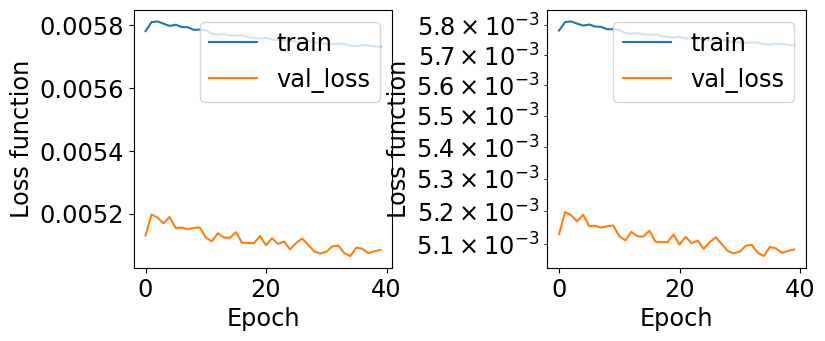

In [92]:
plf.plotTrainHistory(history_weather)

# Zadanie domowe

**Proszę:**

* dodać do obiektu `pandas.DataFrame` kolumnę z numerem tygodnia
* skonstruować model, który jako sekwencje wejściowe będzie brał dane z ulic:
    ```Python
    ["Mogilska", "Kotlarska", "Bulwary", "Wadowicka", "Wielicka"]
    ```
   oraz numer dnia tygodnia
* jako dane o pogodzie będzie przyjmował kolumny `suma opadu dzień  [mm]` i `temperatura [°C]`
* przyjąć że pierwsza ulica z listy to ulica, dla której jest liczona prognoza
* zbiór treningowy ograniczyć do okresu `2017 - 2021`
* zbiór walidacyjny ograniczyć do okresu `2022 - 2024`
* sprawdzić czy dane w obiekcie `tf.data.Dataset` są dobrze przygotowane
* przeprowadzić trening
* narysować rysunki kontrolne dla ulicy `Mogilskiej` (takie jak na wykładzie)
    * górny wiersz dla zakresu `01.05.2024 - 31.07.2024`
    * dolny dla zakresu `01.08.2024 - 31.12.2024`
* przeprowadzić trening dla różnych szerokości okna czasowego i wskazać dającą najlepsze. Jako metryki użyć `średniego błedu kwadratowego` na zbiorze walidacyjnym.

In [ ]:
# add day of week to data
...rozwiązanie...
pass

In [ ]:
# prepare traion and validation datasets
...rozwiązanie...
item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

In [ ]:
# check if the data is aligned
...rozwiązanie...
pass

In [ ]:
# contruct model
...rozwiązanie...
#Run model on trainig dataset to check if it works
model.predict(train_dataset);

In [ ]:
# prepare plotting function
...rozwiązanie...
    pass

In [ ]:
# train model and make control plots
...rozwiązanie...
pass

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


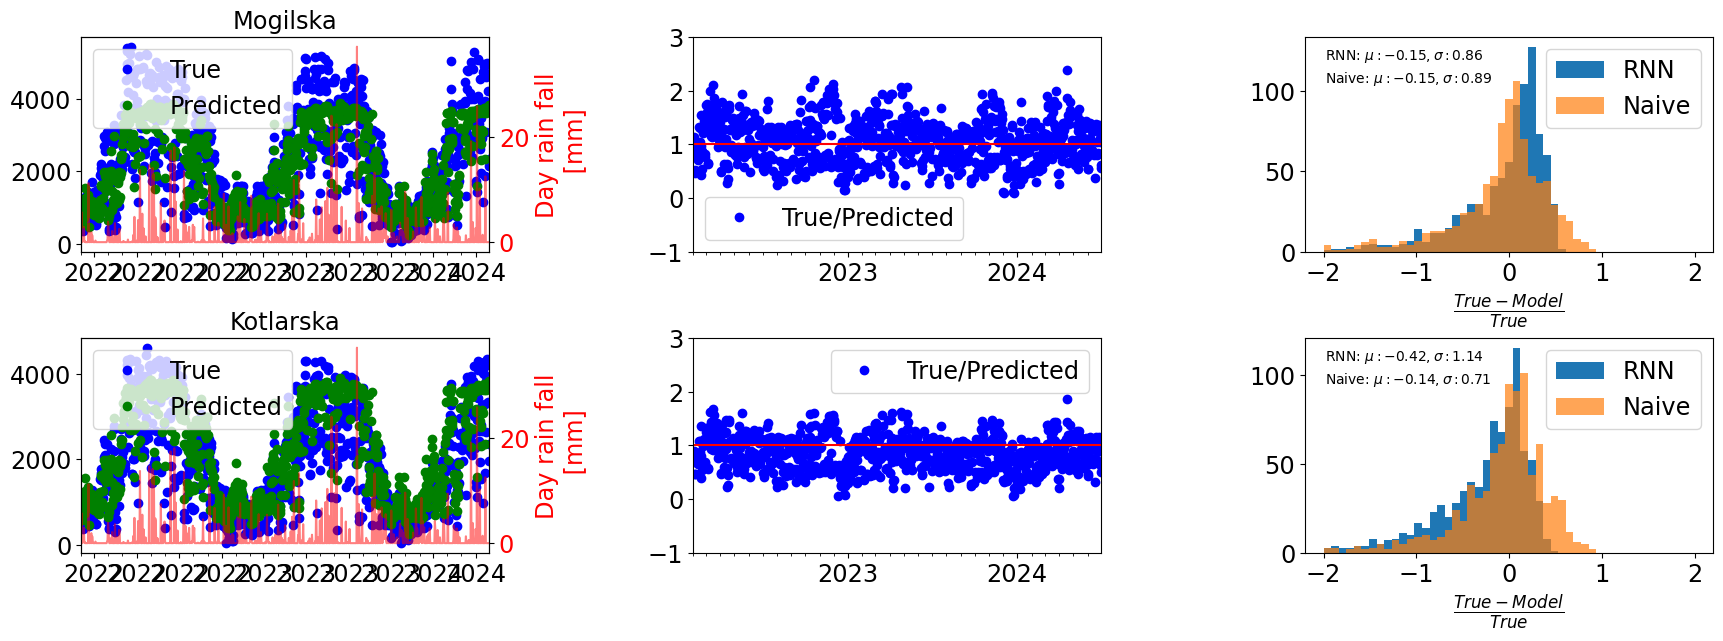

In [91]:
# Adapt the plotPrediction function to accept featureColumns
def plotPrediction_with_weather(model, df, makeDataset_func, streets, featureColumns, window_size, scale):
    fig, axes = plt.subplots(2,3, figsize=(17,6))
    import matplotlib.dates as mdates

    for index,street in enumerate(streets[:2]):
        df_tmp = df[minValDate:maxValDate]
        dataset = makeDataset_func(df=df_tmp, sequenceColumns=[street],
                              featureColumns=featureColumns, # Pass featureColumns
                              window_size=window_size,
                              scale=scale)
        date = df_tmp.index[window_size-1:]
        y = df_tmp[street][window_size-1:].values

        # Make predictions
        y_pred = model.predict(dataset)*scale
        y_pred = y_pred.flatten() # Flatten y_pred to match shape of y

        # Naive model prediction
        y_pred_naive = np.roll(y,1)

        # Plotting the predictions vs true values for a specific date range
        axes[index,0].plot(date,y,'bo',label="True") # Changed to plot a scatter
        axes[index,0].plot(date,y_pred,'go',label="Predicted") # Changed to plot a scatter
        axes[index,0].set_xlim([date.min(), date.max()]) # Set x-axis to cover the whole period
        axes[index,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Adjusted major locator
        axes[index,0].xaxis.set_minor_locator(mdates.MonthLocator()) # Adjusted minor locator
        axes[index,0].set_title(street)
        axes[index,0].legend()

        # Plotting the ratio of true to predicted values
        # Avoid division by zero if y_pred is zero
        ratio = np.divide(y, y_pred, out=np.zeros_like(y, dtype=float), where=y_pred!=0)
        axes[index,1].plot(date, ratio,'bo',label="True/Predicted") # Changed to plot a scatter
        axes[index,1].plot([date.min(),date.max()],[1,1],'r')
        axes[index,1].set_xlim([date.min(), date.max()]) # Set x-axis to cover the whole period
        axes[index,1].xaxis.set_major_locator(mdates.YearLocator())
        axes[index,1].xaxis.set_minor_locator(mdates.MonthLocator())
        axes[index,1].set_ylim([-1,3])
        axes[index,1].legend()


        # Plotting histograms of relative errors
        # Avoid division by zero if y is zero
        pull_rnn = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        pull_naive = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)

        counts, bins, _ = axes[index,2].hist(pull_rnn, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist(pull_naive, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")

        # Add mean and std text to the histogram
        mean_rnn = np.mean(pull_rnn)
        std_rnn = np.std(pull_rnn)
        axes[index,2].text(0.05, 0.95, r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean_rnn, std_rnn), transform=axes[index,2].transAxes, verticalalignment='top')

        mean_naive = np.mean(pull_naive)
        std_naive = np.std(pull_naive)
        axes[index,2].text(0.05, 0.85, r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean_naive, std_naive), transform=axes[index,2].transAxes, verticalalignment='top')

        axes[index,2].legend()

        # Plotting rain data if available
        opadyColumn = "suma opadu dzień  [mm]"
        if opadyColumn in df.columns:
            ax2 = axes[index,0].twinx()
            ax2.plot(date, df_tmp[opadyColumn][window_size-1:]*40, 'r', alpha=0.5); # Scale back for plotting
            ax2.tick_params(axis='y', labelcolor="r")
            ax2.yaxis.label.set_color('red')
            ax2.set_ylabel("Day rain fall\n [mm]")

    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.5, hspace=0.4)
    plt.show()

# Use functools.partial to create a version of makeDataset with fixed featureColumns
makeDataset_with_features = functools.partial(makeDataset, featureColumns=featureColumns)

# Plot the predictions
plotPrediction_with_weather(model_with_weather, df_merged, makeDataset_with_features, [train_street, val_street], featureColumns, window_size, scale)